<a href="https://colab.research.google.com/github/levimcclenny/notebooks/blob/main/Notebook2_Allen_Cahn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Allen-Cahn using the SA-PINN

In this example we will explore a few more advanced features of TensorDiffEq, such as self-adaptive solving, in order to solve harder systems of PDEs. In this example, we will solve the Allen-Cahn equation, taking the form:

$u_t -0.0001u_{xx} + 5u^3 -5u = 0\,, \ \  x \in [-1,1], \ t \in [0,1]\,, $ \\
$ u(x, 0) = x^2cos(\pi x)\,$ \\
$ u(t, -1) = u(t,1)\, $ \\
$ u_x(t,-1) = u_x(t,1)\ $

Similar to last time, we first must install the *TensorDiffEq* package

In [1]:
!pip install tensordiffeq

     |████████████████████████████████| 870kB 32.1MB/s 
  Created wheel for pyDOE2: filename=pyDOE2-1.3.0-cp37-none-any.whl size=25519 sha256=988aacc17533e4dbd0f96773418db68da6440f8bb4571608d0c646832ca23d7d
  Stored in directory: /root/.cache/pip/wheels/60/88/1d/b334ee00dd83e82d111ec56c3be91573d335c93870698037f1
Successfully built pyDOE2


First, necessary imports. Then we define the domain - a simple 1D w/time domain, and generate collocation points in that domain,

In [2]:
import math
import scipy.io
import tensordiffeq as tdq
from tensordiffeq.boundaries import *
from tensordiffeq.models import CollocationSolverND

Domain = DomainND(["x", "t"], time_var='t')

Domain.add("x", [-1.0, 1.0], 512)
Domain.add("t", [0.0, 1.0], 201)

N_f = 10000
Domain.generate_collocation_points(N_f)

Next, we define the IC function, the derivative model which is implemented at the boundaries of the periodic BC (i.e. first order, second order, etc). Then we define the IC/BC classes and stack them into a list to feed into the solver.

In [3]:
def func_ic(x):
    return x ** 2 * np.cos(math.pi * x)


# Conditions to be considered at the boundaries for the periodic BC
def deriv_model(u_model, x, t):
    u = u_model(tf.concat([x, t], 1))
    u_x = tf.gradients(u, x)[0]
    return u, u_x


init = IC(Domain, [func_ic], var=[['x']])
x_periodic = periodicBC(Domain, ['x'], [deriv_model])

BCs = [init, x_periodic]

Now we define our strong-form PDE using the tf.gradients syntax

In [4]:
def f_model(u_model, x, t):
    u = u_model(tf.concat([x, t], 1))
    u_x = tf.gradients(u, x)
    u_xx = tf.gradients(u_x, x)
    u_t = tf.gradients(u, t)
    c1 = tdq.utils.constant(.0001)
    c2 = tdq.utils.constant(5.0)
    f_u = u_t - c1 * u_xx + c2 * u * u * u - c2 * u
    return f_u

In order to implement the self-adaptive solvers we must define tf.Variable vectors of length corresponding to the number of points in the domain, in this case N_f is the number of collocation points and 512 is the number of initial boundary points (from the Domain cell)

In [5]:
col_weights = tf.Variable(tf.random.uniform([N_f, 1]), trainable=True, dtype=tf.float32)
u_weights = tf.Variable(100 * tf.random.uniform([512, 1]), trainable=True, dtype=tf.float32)

Define the network layer sizes

In [6]:
layer_sizes = [2] 
layer_sizes.extend([128]*4)
layer_sizes.extend([1])
print(layer_sizes)

[2, 128, 128, 128, 128, 1]


Initialize the collocation model and solve using the SA-PINN

In [8]:
model = CollocationSolverND()
model.compile(layer_sizes, f_model, Domain, BCs, isAdaptive=True, col_weights=col_weights, u_weights=u_weights)
model.fit(tf_iter=10000, newton_iter=1000)

  ______                           ____  _ ______________     
 /_  __/__  ____  _________  _____/ __ \(_) __/ __/ ____/___ _
  / / / _ \/ __ \/ ___/ __ \/ ___/ / / / / /_/ /_/ __/ / __ `/
 / / /  __/ / / (__  ) /_/ / /  / /_/ / / __/ __/ /___/ /_/ / 
/_/  \___/_/ /_/____/\____/_/  /_____/_/_/ /_/ /_____/\__, /  
                                                        /_/   

Neural Network Model Summary

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 128) 


Starting L-BFGS training
Executing eager-mode L-BFGS


In [9]:
# Get AC data from repo, requires the ?raw=true so wget doesnt download the webpage instead of the data!
!wget --no-check-certificate https://github.com/tensordiffeq/TensorDiffEq/blob/main/examples/AC.mat?raw=true \
    -O AC.mat

--2021-05-06 04:05:56--  https://github.com/tensordiffeq/TensorDiffEq/blob/main/examples/AC.mat?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/tensordiffeq/TensorDiffEq/raw/main/examples/AC.mat [following]
--2021-05-06 04:05:56--  https://github.com/tensordiffeq/TensorDiffEq/raw/main/examples/AC.mat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tensordiffeq/TensorDiffEq/main/examples/AC.mat [following]
--2021-05-06 04:05:56--  https://raw.githubusercontent.com/tensordiffeq/TensorDiffEq/main/examples/AC.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP re

training pass 1 completed
Error u: 6.747827e-02


No handles with labels found to put in legend.


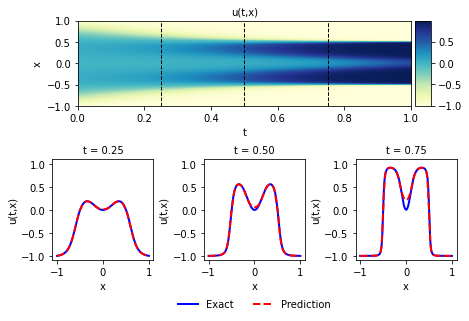

In [10]:

save_model = model.u_model
print("training pass 1 completed")

# Load high-fidelity data for error calculation
data = scipy.io.loadmat('AC.mat')

Exact = data['uu']
Exact_u = np.real(Exact)

# t = data['tt'].flatten()[:,None]
# x = data['x'].flatten()[:,None]

x = Domain.domaindict[0]['xlinspace']
t = Domain.domaindict[1]["tlinspace"]

# create mesh for plotting

X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact_u.T.flatten()[:, None]

# forward pass through model
u_pred, f_u_pred = model.predict(X_star)

error_u = tdq.helpers.find_L2_error(u_pred, u_star)
print('Error u: %e' % (error_u))

U_pred = tdq.plotting.get_griddata(X_star, u_pred.flatten(), (X, T))
FU_pred = tdq.plotting.get_griddata(X_star, f_u_pred.flatten(), (X, T))

lb = np.array([-1.0, 0.0])
ub = np.array([1.0, 1])

tdq.plotting.plot_solution_domain1D(model, [x, t], ub=ub, lb=lb, Exact_u=Exact_u)